# Algorithm for a Dog Identification App 

Nowadays, it seems that we have unlimited access to data. Especially when it comes to good quality photos. Each of us has a smartphone that we use to document scenes from our lives. One of the things we love to photograph are our pets.

One of the most popular uses of neural networks (and especially of convolutional neural networks) is object recognition in photos. The purpose is to conveniently segregate data, create amazing applications of augmented reality or intelligent analysis of monitoring recordings.

In this notebook I will show you how to create a convolution network that can distinguish between 133 different breeds of dogs based on photos.

It's not always that easy! Take a look at these two examples:

![Sample Dog Output1](images/Brittany_02625.jpg) ![Sample Dog Output2](images/Welsh_springer_spaniel_08203.jpg)

One of them is brittany and other is welsh springer spaniel. Can you guess which one is which? Now you don't have to! Follow cells in this notebook and check it on your own!

The problem we face is the recognition of a dog breed based on any uploaded photo. We will measure the success of the model by accuracy, where the cost function will be CategoricalCrossEntropy. To do this we will use a modern library to create deep neural networks Tensorflow 2.0. You can check the operation of the model here or in the web application that I placed in this repository.

Have fun :)

In [1]:
import os
from os.path import isfile, isdir
import pathlib
import pickle as pkl
import random
from glob import glob

import collections
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.datasets import load_files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
from tensorboard.plugins.hparams import api as hp

In [2]:
tf.__version__ # make sure that it's higher than 2.0.0

'2.1.0'

Here we are initializing global variables useful in data displaying and learning model

In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

**Set path to dog images**
## Be careful data is not included in this repository! If you want you can download it from web application level or by following link below
<a href="https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip" class="text-white">Download dataset</a>

In [4]:
dogs_dir = "dogImages" # must be in the same folder as notebook
train_dir = dogs_dir + "/train"
test_dir = dogs_dir + "/test"
valid_dir = dogs_dir + "/valid"

# Load and investigate data

Here we will use ImageDataGenerator wich is class from tf.keras that generate batches of tensor image data with real-time data augmentation.
Tensors are needed form of data to feed in model, so we will use this convenient class to do the work for us.
As another plus it also one hot encodes our labels so assuming that we have only three clases they will be mapped as:
breed1 - [0, 0, 0]
breed2 - [1, 0, 0]
breed3 - [0, 1, 0]

Method flow_from_directory will automaticaly read data from provided directory if folder structure looks like this:

In [5]:
image_generator = image.ImageDataGenerator(rescale=1/255) #rescale images to [0-1] range

# load data and reshape them to 224 pixels x 224 pixels
print("Train data: ")
train_image_data = image_generator.flow_from_directory(str(train_dir), target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE)
print("Test data: ")
test_image_data = image_generator.flow_from_directory(str(test_dir), target_size=(IMG_WIDTH, IMG_HEIGHT))
print("Validation data: ")
valid_image_data = image_generator.flow_from_directory(str(valid_dir), target_size=(IMG_WIDTH, IMG_HEIGHT))

Train data: 
Found 6680 images belonging to 133 classes.
Test data: 
Found 836 images belonging to 133 classes.
Validation data: 
Found 835 images belonging to 133 classes.


**Ok so we can see that the number of classes is 133, that's quite a lot. Let's see what kind of breeds are available in our dataset.**

In [6]:
num_of_classes = 133

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = tf.keras.utils.to_categorical(np.array(data['target']), num_of_classes)
    return dog_files, dog_targets


def clean_label(label):
    """Data looks like this '000.some_breed', here we are converting it to 'some breed'"""
    return label.split(".")[1:][0].replace("_", " ")


# load train, test, and validation datasets
# we already know this number from image_generator but we can double check
train_images, train_targets = load_dataset(train_dir)
valid_images, valid_targets = load_dataset(valid_dir)
test_images, test_targets = load_dataset(test_dir)

print(f"""Num of train images: {len(train_targets)}
Num of valid images: {len(valid_targets)}
Num of test images: {len(test_targets)}
Total number of images: {len(train_targets) + len(valid_targets) + len(test_targets)}\n""")

num_of_dog_classes = 133

Num of train images: 6680
Num of valid images: 835
Num of test images: 836
Total number of images: 8351



Now let's see how much data do we have for each breed by creating training images distribution

In [7]:
images_dist = {}

for item in sorted(glob(f"{train_dir}/*/")):
    item = item.split('/')[-2]
    images_dist[clean_label(item)] = len([name for name in os.listdir(f'{train_dir}/{item}')])

dog_names = list(images_dist.keys())

print("Sample classes names: ")
shuffled_dog_names = dog_names.copy()
random.shuffle(shuffled_dog_names)
shuffled_dog_names[:10]

Sample classes names: 


['Alaskan malamute',
 'Bullmastiff',
 'Miniature schnauzer',
 'Cane corso',
 'Great pyrenees',
 'Pomeranian',
 'Anatolian shepherd dog',
 'Bichon frise',
 'Neapolitan mastiff',
 'Boston terrier']

In [8]:
images_dist_df = pd.DataFrame(images_dist.items(), columns=["Breed", "Image samples"])
images_dist_df

Breed  Image samples
0                  Affenpinscher             64
1                   Afghan hound             58
2               Airedale terrier             52
3                          Akita             63
4               Alaskan malamute             77
..                           ...            ...
128              Tibetan mastiff             48
129       Welsh springer spaniel             44
130  Wirehaired pointing griffon             30
131               Xoloitzcuintli             26
132            Yorkshire terrier             30

[133 rows x 2 columns]

In [9]:
images_dist_df.describe()

Image samples
count     133.000000
mean       50.225564
std        11.863885
min        26.000000
25%        42.000000
50%        50.000000
75%        61.000000
max        77.000000

In [10]:
images_dist_df.loc[images_dist_df["Image samples"] == 26]

Breed  Image samples
107  Norwegian buhund             26
131    Xoloitzcuintli             26

In [11]:
images_dist_df.loc[images_dist_df["Image samples"] == 77]

Breed  Image samples
4  Alaskan malamute             77

**It seems that we have 50 images on average for every breed. Minimal number of samples is 26 and this applies to Norwegian buhund and Xoloitzcuintli. On the other way we have biggest number of samples for Alaskan malamute, which is 77.**

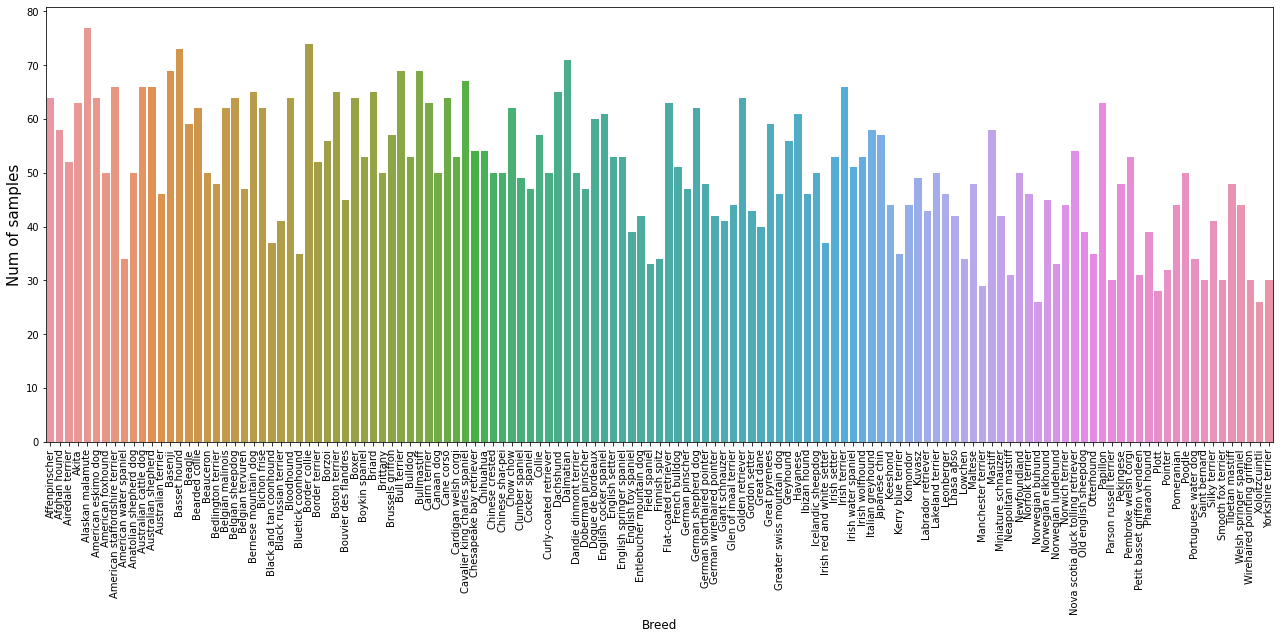

In [12]:
def plot_dist(breed, occurences):
    """
    Plots seaborn barplot with breed distribution
    """
    fig = plt.figure(figsize=(22, 8))
    sns.barplot(breed, occurences)
    plt.ylabel('Num of samples', fontsize=15)
    plt.xlabel('Breed', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()
    
plot_dist(images_dist_df["Breed"], images_dist_df["Image samples"])

# So how out images looks like? Check this out!

In [13]:
def show_batch(image_batch, label_batch):
    """Shows batch of images generated by ImageDataGenerator"""
    plt.figure(figsize=(15,15))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        plt.axis('off')
    plt.show()

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 133)


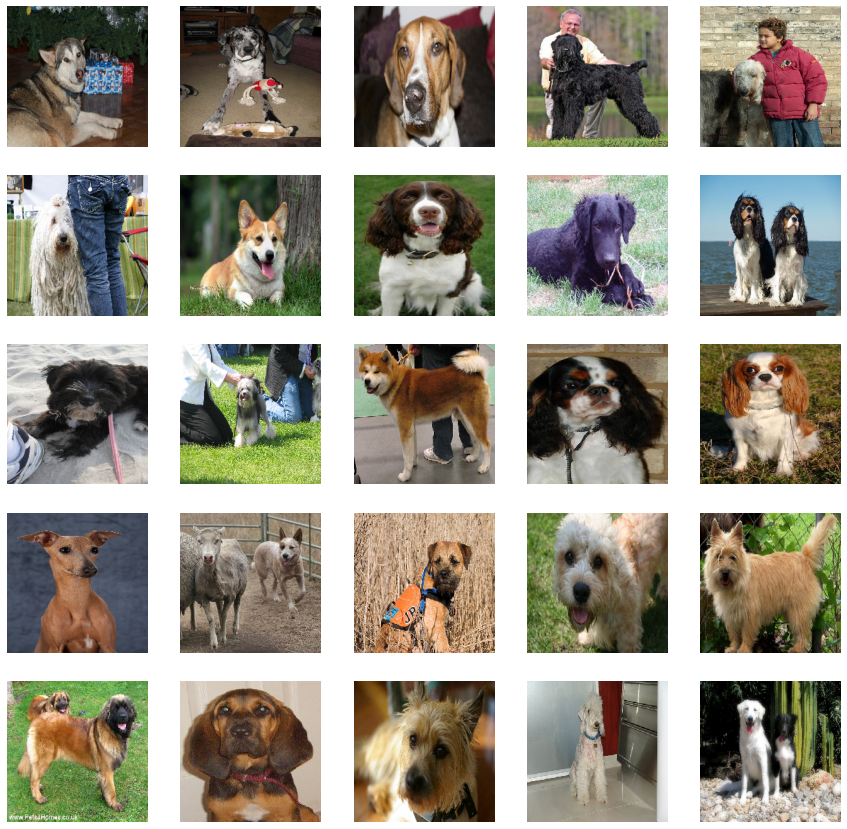

In [14]:
for image_batch, label_batch in train_image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)

    show_batch(image_batch, label_batch)
    break

# That's some nice looking dogs!
**You can continue with using train_image_data initialized before and even augmenting it, but if you want to make things faster load prepared bottleneck features, which are precomputed features for ResNet50 architecture. Either way I will give you opportinity to go both ways.**

In [15]:
# pretrained bottleneck resnet50 reatures
def load_pretrainted_resnet_features(path):
    """Loads and returns precomputed features for ResNet50 architecture"""
    bottleneck_features = np.load(path)

    train_resnet = bottleneck_features['train']
    valid_resnet = bottleneck_features['valid']
    test_resnet = bottleneck_features['test']

    return train_resnet, valid_resnet, test_resnet

train_resnet, valid_resnet, test_resnet = load_pretrainted_resnet_features("../dogs_breed_classifier/data/bottleneck_features/resnet_embeddings.npz")

In cell aboce we will perform data augmentation which constists of:

**rescale** - changing each pixel value to range [0..1]

**rotation_range** - image random rotation

**width_shift_range, height_shift_range** - randomly shifting image horizontaly and verticaly

**zoom_range** - randomly zooms image

**horizontal_flip** - randolmy makes mirror reflection

In [16]:
augmented_image_generator = ImageDataGenerator(
    rescale=1/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 6680 images belonging to 133 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 133)


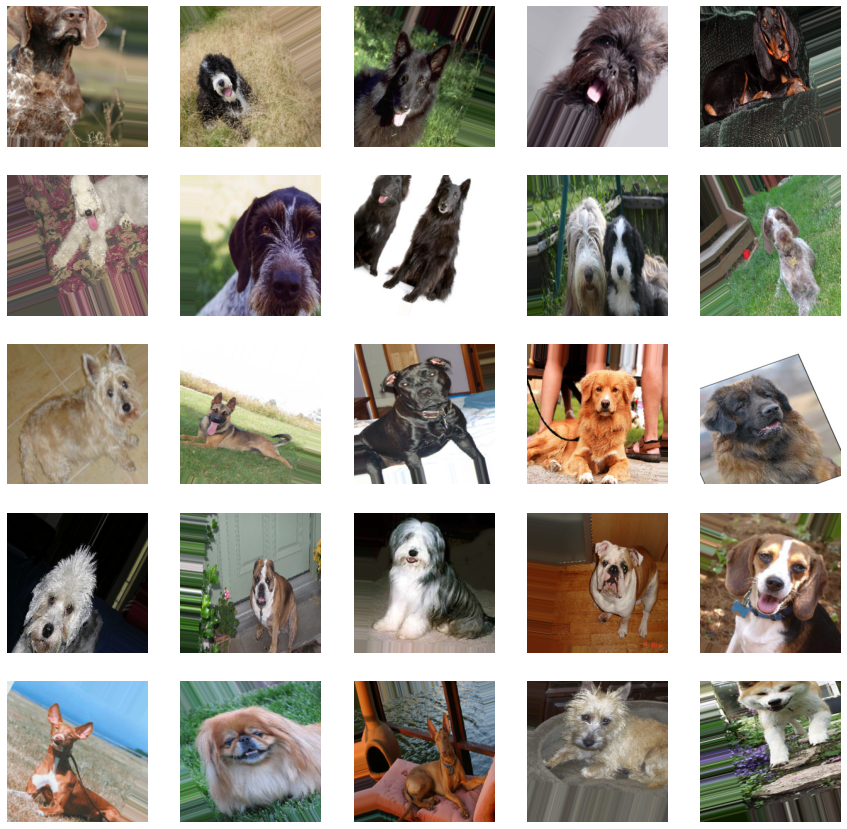

In [17]:
augmented_train = augmented_image_generator.flow_from_directory(train_dir, target_size=(IMG_WIDTH, IMG_HEIGHT) ,batch_size=BATCH_SIZE)
for image_batch, label_batch in augmented_train:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)

    show_batch(image_batch, label_batch)
    break

Nice! Now our data if in form of tensors with shape (32, 224, 224, 3) and we are ready to do our training. Lets begin with...

# Creating your model

Convolutional neural network CNN is a deep learning algorithm that can take an input image, assign weight (readable weight and deviation) to various objects in the image, and be able to distinguish one from the other. If you want to know more abot CNNs pleas refer to this really good towards data science 
<a href="https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53">post</a>.

In this notebook I will use ResNet50 architecture which you can get familiar with by reading another great
<a href="https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33">article</a>.

If you don't want to use bottleneck features download ResNet50 architecture and add some extra layers at the end, whith 133 classes as output.

In [18]:
pretrained_resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense = tf.keras.layers.Dense(512)
dropout = tf.keras.layers.Dropout(0.4)
prediction_layer = tf.keras.layers.Dense(num_of_dog_classes, activation="softmax")

In [20]:
# that's my proposition, you can go wild and be creative!
pretrained_model = tf.keras.Sequential([
    pretrained_resnet,
    global_average_layer,
    dense,
    dropout,
    prediction_layer
])

In [21]:
pretrained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               68229     
Total params: 24,705,029
Trainable params: 24,651,909
Non-trainable params: 53,120
_________________________________________________________________


As you can see at above summary I've used resnet50 architecture pretrained at imagenet data. During initialization I've set the parameter include_top=False which means that I want to throw away the last layer which is prediction layer with 1000 output units (imagenet has 1000 different classes). Instead I need to provide some other network output. I could easly just add dense prediction layer with 133 classes but it this case I decided to add also:

global_average_pooling2d - this layer flattens a 3D tensor (let say 7,7,10) and compute the average over the 7,7 slices, you end up with a 3D tensor of shape 1,1,10 that you reshape into a 1D vector of shape 10. This is needed to pass this tensor into fully connected layer which comes next

**dense** - regular fully connected layer, in this case with 512 units

**dropout** - randomly shuts down some % of the neurons, in this case 40%

**dense_1** - that's mentioned earlier prediciton layer with softmax activation funtion

In [22]:
pretrained_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

If you don't want to speed up training (or you don't have fast GPU) please use already pretrained features and create model like this:

In [23]:
resnet_model = tf.keras.Sequential([
    global_average_layer,
    dense,
    dropout,
    prediction_layer
])

I will go with faster solution so:

In [24]:
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
def decay(epoch):
    """Learning scheduler, reduces learning rate depending on the epochs"""
    if epoch < 10:
        return 1e-2
    else:
        return 1e-3

In [26]:
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        """Shows learning rate during training"""
        print('\nLearning rate for epoch {} is {}'.format(
            epoch + 1, resnet_model.optimizer.lr.numpy()))

In [27]:
checkpoint_dir = "checkpoints"
checkpoint_path = checkpoint_dir + "/weights.best.resnet.hdf5"

if not isdir(checkpoint_dir):
    !mkdir "checkpoints"
else:
    print("Path already exists")

# Create a callback that saves the model's weights
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True,
        verbose=1),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR(),
]

Path already exists


In [28]:
bottleneck_features = True
epochs = 15

if bottleneck_features:
    history = resnet_model.fit(
        train_resnet,
        train_targets, 
        validation_data=(
            valid_resnet,
            valid_targets),
        epochs=epochs,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1,
        )
else:
    history = pretrained_model.fit(
        augmented_train,
        validation_data=valid_image_data,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1,
    )

Train on 6680 samples, validate on 835 samples
Epoch 1/15
6656/6680 [============================>.] - ETA: 0s - loss: 34.6613 - accuracy: 0.3896
Epoch 00001: val_loss improved from inf to 28.54765, saving model to checkpoints/weights.best.resnet.hdf5

Learning rate for epoch 1 is 0.009999999776482582
6680/6680 [==============================] - 2s 228us/sample - loss: 34.6251 - accuracy: 0.3904 - val_loss: 28.5477 - val_accuracy: 0.5928
Epoch 2/15
6656/6680 [============================>.] - ETA: 0s - loss: 43.6676 - accuracy: 0.5990
Epoch 00002: val_loss did not improve from 28.54765

Learning rate for epoch 2 is 0.009999999776482582
6680/6680 [==============================] - 1s 151us/sample - loss: 43.8382 - accuracy: 0.5984 - val_loss: 52.1111 - val_accuracy: 0.6060
Epoch 3/15
6528/6680 [============================>.] - ETA: 0s - loss: 48.7235 - accuracy: 0.6786
Epoch 00003: val_loss did not improve from 28.54765

Learning rate for epoch 3 is 0.009999999776482582
6680/6680 [====

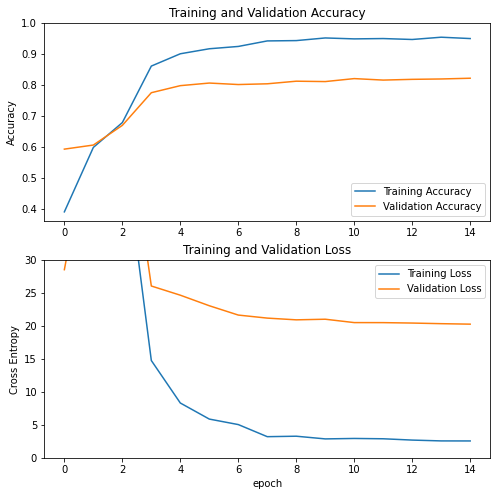

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,30.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
resnet_model.load_weights(checkpoint_path)

# Evaluation

In [31]:
resnet_predictions = [np.argmax(resnet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_resnet]

test_accuracy = 100 * np.sum(np.array(resnet_predictions)==np.argmax(test_targets, axis=1)) / len(resnet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.1770%


That's pretty high accuracy for 133 classes. Let's see if we can better.

# Parameter tuning

In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are learned.

In [80]:
#load tensorboard extension

In [79]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [51]:
!rm -rf ./logs/ # clear logs from previous executions if present

Define out hyperparameters. In this case it will be: number of units in the added dense layer, percent of silenced neurons in dropout layer and optimizer

In [52]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([256, 512, 1024]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.4))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'rmsprop']))

Set our metrics

In [53]:
METRIC_ACCURACY = 'accuracy'

Save metrics into logs/hparam_tuning file for displaying it in tensorboard

In [54]:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In the cell below you can see that all of it looks familliar and you souldn't have problem to cacht up. 
You can notice that i change one more thing. Not activation layer of fully connected layer after global average pooling is selu. You can read about it in this great article: https://towardsdatascience.com/selu-make-fnns-great-again-snn-8d61526802a9


In [58]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/hparam_tuning", histogram_freq=1)

def train_test_model(hparams, checkpoint_name):
    model = tf.keras.models.Sequential([
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation="selu"),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
        tf.keras.layers.Dense(num_of_dog_classes, activation="softmax"),
    ])
    
    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='categorical_crossentropy',
      metrics=['accuracy'],
    )

    model.fit(
        train_resnet,
        train_targets, 
        validation_data=(
            valid_resnet,
            valid_targets),
        epochs=15,
        callbacks=[
            tensorboard_callback,
            tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_dir + f"/weights.best.{checkpoint_name}.hdf5",
                save_best_only=True,
                verbose=1),
            tf.keras.callbacks.LearningRateScheduler(decay)
        ],
        batch_size=BATCH_SIZE,
        verbose=1,
    )
    _, accuracy = model.evaluate(test_resnet, test_targets)
    return accuracy

In [59]:
def run(run_dir, hparams, checkpoint_name):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams, checkpoint_name)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

# Run training with hyperparameters. Be careful! That might take a while especially if you are not using bottleneck parameters!

In [60]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
        
            hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams, run_name)
            session_num += 1

--- Starting trial: run-0
{'num_units': 256, 'dropout': 0.1, 'optimizer': 'adam'}
Train on 6680 samples, validate on 835 samples
Epoch 1/15
6400/6680 [===========================>..] - ETA: 0s - loss: 4.7230 - accuracy: 0.3236
Epoch 00001: val_loss improved from inf to 3.06179, saving model to checkpoints/weights.best.run-0.hdf5
6680/6680 [==============================] - 1s 174us/sample - loss: 4.6487 - accuracy: 0.3316 - val_loss: 3.0618 - val_accuracy: 0.5234
Epoch 2/15
6432/6680 [===========================>..] - ETA: 0s - loss: 3.6320 - accuracy: 0.5197
Epoch 00002: val_loss did not improve from 3.06179
6680/6680 [==============================] - 1s 116us/sample - loss: 3.6326 - accuracy: 0.5204 - val_loss: 3.8207 - val_accuracy: 0.5533
Epoch 3/15
6592/6680 [============================>.] - ETA: 0s - loss: 3.7549 - accuracy: 0.5921
Epoch 00003: val_loss did not improve from 3.06179
6680/6680 [==============================] - 1s 114us/sample - loss: 3.7556 - accuracy: 0.5921 - 

Finally end! You can investigate our results in awesome tool which is tensorboard. It has a lot of amazing features but at this time we are mostly interested in our test accuracy.

In [61]:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 8827), started 2:09:41 ago. (Use '!kill 8827' to kill it.)

In my case best was run-17 and it's achieved 83,73% accuracy: {'num_units': 1024, 'dropout': 0.1, 'optimizer': 'sgd'}.
Now we can recreate it and load weights.

If you want to achieve even better results, try playing yourself. Add hidden layers, change activation functions, try using an operation called batch normalization, or experiment with the number of neurons! The possibilities are endless and only your curiosity limits you.

In [69]:
resnet_model = tf.keras.Sequential([
    tf.keras.layers.GlobalAveragePooling2D(input_shape=(7, 7, 2048)),
    tf.keras.layers.Dense(1024, activation="selu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_of_dog_classes, activation="softmax"),
])

resnet_model.compile(
    optimizer="sgd",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

resnet_model.load_weights("checkpoints/weights.best.run-17.hdf5")

In [70]:
def extract_resnet50(tensor):
    """Converts image tensor to resnet bottleneck feature"""
    return tf.keras.applications.ResNet50(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

In [71]:
def resnet_predict_breed(img_path):
    """Predics dog breed on image from image_path"""
    # extract bottleneck features
    bottleneck_feature = extract_resnet50(path_to_tensor(img_path))
    # obtain predicted vecto
    predicted_vector = resnet_model.predict(bottleneck_feature)[0]

    # return dog breed that is predicted by the model
    indices = predicted_vector.argsort()[-3:][::-1]
    names = [dog_names[index] for index in indices]
    percentages = [100 * predicted_vector[index] for index in indices]
    
    return names, percentages

# Extra: Recognize if there is a man in the picture and tell which dog he is most like

Number of faces detected: 1


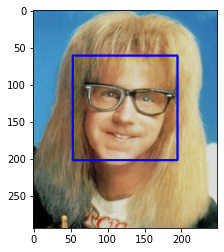

In [72]:
import cv2                      
%matplotlib inline                    

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('../dogs_breed_classifier/data/cascade_classifier/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread("images/sample_human_2.png")
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [73]:
def face_detector(img_path, facecascade):
    """Detects human faces, returns true if face will be found at image"""
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = facecascade.detectMultiScale(gray)
    return len(faces) > 0

In [74]:
imagenet_resnet = tf.keras.applications.ResNet50(weights='imagenet')

def path_to_tensor(img_path):
    """Converts image path to image tensor"""
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def dog_detector(img_path):
    """Detects if there is dog at the image"""
    img = preprocess_input(path_to_tensor(img_path))
    prediction = np.argmax(imagenet_resnet.predict(img))

    return ((prediction <= 268) & (prediction >= 151))

# Now it's time to check our model in practice!

In [75]:
def make_predictions(img_path):
    """
    Given model and image path predicts if there is human or dog on the image.
    Either way it predicts what breed of dog is it (or could be).
    """
    if face_detector(img_path, face_cascade):
        names, percentages = resnet_predict_breed(img_path)
        answer = ""
        for name, percent in zip(names, percentages):
            answer += f"\n{name} ({percent:.4} %)"
        response = f"I'm pretty sure that's human!\nBut as a dog it could be... {answer}"
    elif dog_detector(img_path):
        names, percentages = resnet_predict_breed(img_path)
        answer = ""
        for name, percent in zip(names, percentages):
            answer += f"\n{name} ({percent:.4} %)"
        response = f"That's a dog! and he looks like... {answer}"
    else:
        response = "I can't recognize what is that :<"
        
    plt.figure(figsize=(5, 5))
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(response)
    plt.axis('off')
    plt.show()

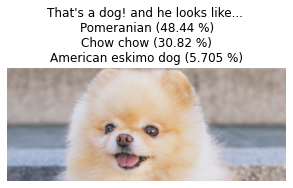

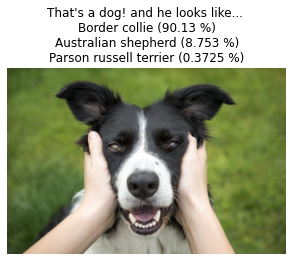

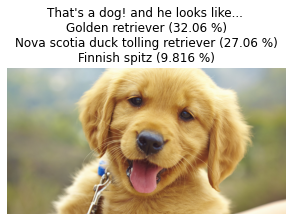

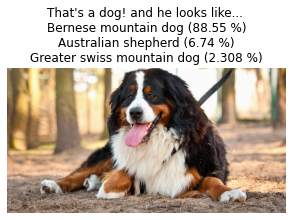

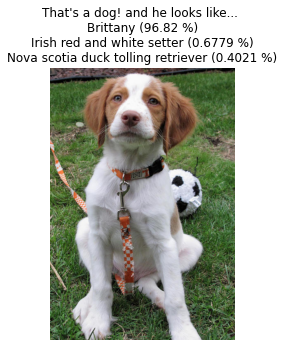

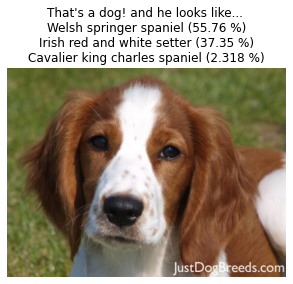

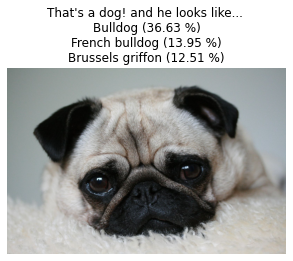

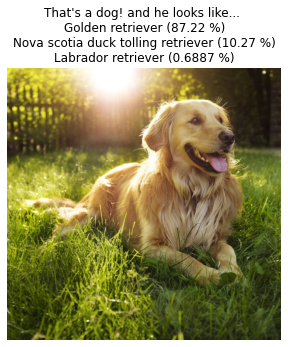

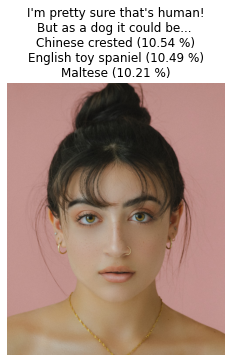

In [76]:
for path in pathlib.Path("uploaded_images").glob("**/*.jpg"):
    make_predictions(str(path))

# Conclusions

We did a great job! As you can see nowadays, everyone with a bit of desire has the opportunity to create a machine learning model that copes with such a complex task as recognizing dogs in images. We used modern architecture of convolution networks and managed to improve its performance as a result of tuning parameters. The above notebook can be used to recognize virtually any object in the image. Just find the right dataset. In the meantime, I encourage you to run the application and see how the model is doing in the real world!